# 2.3 Decoding of trial epoch

In [3]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode

# --Machine learning and statistics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from postprocessing_functions import define_trial_types, bin_sequence, decoder
from plotting_functions import plot_binned_sequence
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')

## Parameters

In [4]:
# Parameters
bin_size = 0.017
multiplier = 1
num_states = 2
num_iters = 100
threshold = 0.05
sticky = False
optimal_k = 4
num_train_batches = 20

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

save_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'

# LOAD DATA
data_path ='/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

states_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
wavelet_states_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/wavelet_transform_states/'

use_sets = [['whisker_me'], ['Lick count'], ['0.5',
    '1.0', '2.0', '4.0', '8.0']]
use_sets = [['avg_wheel_vel'], ['whisker_me'], ['Lick count'], ['0.25', '0.5',
    '1.0', '2.0', '4.0', '8.0', '16.0']]
var_interest_map = ['whisker_me', 'Lick count', 'wavelet']
var_interest_map = ['wavelet', 'whisker_me', 'Lick count']

path_sets = [wavelet_states_path, states_path, states_path]

idx_init_list = [1, 2, 4]
idx_end_list = [2, 3, 8]
# var_interest = 'avg_wheel_vel'


# Individual sessions

In [5]:
# Identify sessions available to process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    whisker_filename = os.path.join(states_path, "most_likely_states" + 'whisker_me' + '_' + fit_id)
    licks_filename = os.path.join(states_path, "most_likely_states" + 'Lick count' + '_' + fit_id)
    wavelet_filename = os.path.join(wavelet_states_path, "most_likely_states_" + str(optimal_k) + '_' + fit_id)

    if os.path.exists(whisker_filename) and os.path.exists(licks_filename) and os.path.exists(wavelet_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


## Get states per trial epoch

In [6]:
# Load preprocessed data
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/'
filename_states = str(results_path + 'states_trial_type02-21-2025')
states_file = pd.read_parquet(filename_states, engine='pyarrow')

In [26]:
trial_epochs = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

keys = np.arange(0, len(trial_epochs))
mapping = {unique: key for unique, key in zip(trial_epochs, keys)}


shufflings = 5  #shuffling
model = GaussianNB()
model = RandomForestClassifier(max_depth=2, random_state=0)

## Trial epoch barcoding

In [1]:
trial_type_agg = ['correct_str', 'contrast_str', 'block_str', 'choice']
trial_type_agg = ['correct_str']
use_metric = 'relative_frequency'  # 'count'
plot = True
len_sequence = [3, 5, 7, 10, 15, 20] 
length = 5
all_decoding_results = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix', 'session'])

# for l, length in enumerate(len_sequence):
for m, mat in enumerate(sessions_to_process[0:1]):

    mouse_name = mat[0]
    session = mat[1]
    fit_id = str(mouse_name+session)

    states_trial = states_file.loc[states_file['session']==session]
    num_states = len(states_trial['most_likely_states'].unique())

    """ Define trial types  """
    states_df = define_trial_types(states_trial, trial_type_agg)
    vars = ['sample', 'trial_type', 'broader_label', 'mouse_name', 'most_likely_states']

    df_grouped = states_trial.groupby(vars[:-1])['most_likely_states'].apply(list).reset_index()
    df_grouped.rename(columns={'most_likely_states': 'sequence'}, inplace=True)
    df_grouped['binned_sequence'] = df_grouped['sequence'].apply(lambda seq: bin_sequence(seq, target_length=length))

    if plot == True:
        states_to_append = np.arange(0, num_states)
        for i in range(10):
            plot_binned_sequence(df_grouped, i, states_to_append)

    df_expanded = df_grouped.join(pd.DataFrame(df_grouped['binned_sequence'].tolist(), columns=[f'col_{i+1}' for i in range(length)]))
    df_expanded['length'] = df_expanded['sequence'].apply(len)
    df_expanded['y'] = df_expanded['trial_type'] + df_expanded['broader_label']
    df_expanded['y'] = df_expanded['broader_label']

    # One-hot encoding
    # df = df_expanded[['col_1', 'col_2',  'col_3', 'col_4', 'col_5']]
    # mat = one_hot_encoder(df)
    # mat['length'] = df_expanded['length'].copy()
    # mat = mat.dropna()
    # mat['y'] = df_expanded['y'].copy()
    
    var = 'y'
    mat = df_expanded.drop(columns=['sample', 'mouse_name', 'trial_type', 'broader_label', 'sequence', 'binned_sequence', 'length']) 
    # mat = mat.drop(columns=[f'col_{i+1}' for i in range(length)]) 
    mat = mat.dropna()

    decoding_result = decoder(mat, var, model, mapping, trial_epochs, shufflings, plot=True)
    
    # decoding_result['session'] = session
    # all_decoding_results = all_decoding_results.append(decoding_result)


NameError: name 'pd' is not defined

In [106]:

# file_to_save = states_trial_type
filename = "timing"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/2_Trial_epoch'
file_format = 'pickle'
script_name = '2.3_trial_epoch_decoder.ipynb'
metadata = save_and_log(all_decoding_results, filename, file_format, save_path, script_name)


## Decode trial epoch

In [160]:
trial_type_agg = ['correct_str', 'contrast_str', 'block_str', 'choice']
trial_type_agg = ['correct_str']
use_metric = 'count'  # 'count'

all_decoding_results = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix', 'session'])

for m, mat in enumerate(sessions_to_process):

    mouse_name = mat[0]
    session = mat[1]
    fit_id = str(mouse_name+session)
    
    states_trial = states_file.loc[states_file['session']==session]
    num_states = len(states_trial['most_likely_states'].unique())

    """ Define trial types  """
    states_df = define_trial_types(states_trial, trial_type_agg)
    vars = ['sample', 'trial_type', 'broader_label', 'mouse_name', 'identifiable_states']
    # Step 1: Group and count occurrences
    count = pd.DataFrame(states_trial.groupby(vars)['identifiable_states'].count())  #  'correct',
    count = count.rename(columns={'identifiable_states': "count"}).reset_index()  # [['trial_type', 'broader_label', 'identifiable_states', 'count']]

    # Step 4: Compute the relative frequency
    count['total'] = count.groupby(vars[:-1])['count'].transform('sum')  # 'broader_label'
    count['relative_frequency'] = count['count'] / count['total']
    # count.loc[count['count']> 0, 'count'] = 1
    
    new_df = count.pivot(index=['sample', 'trial_type', 'mouse_name', 'broader_label'], columns=['identifiable_states'], values=use_metric)
    new_df = new_df.fillna(value=0).reset_index()
    new_df['y'] = new_df['trial_type'] + new_df['broader_label']
    new_df['y'] = new_df['broader_label']
    

    var = 'y'
    mat = new_df.drop(columns=['sample', 'mouse_name', 'trial_type', 'broader_label'])
    mat = mat.dropna()

    decoding_result = decoder(mat, var, model, mapping, trial_epochs, shufflings, plot=False)
    
    decoding_result['session'] = session
    all_decoding_results = all_decoding_results.append(decoding_result)


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:706: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:709: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['contrast_str'] = states_trial_type['contrast'].astype(str)
/home/ines/rep

In [163]:

# file_to_save = states_trial_type
filename = "unique_state"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/2_Trial_epoch'
file_format = 'pickle'
script_name = '2.3_trial_epoch_decoder.ipynb'
metadata = save_and_log(all_decoding_results, filename, file_format, save_path, script_name)

In [103]:
trial_type_agg = ['correct_str', 'contrast_str', 'block_str', 'choice']
trial_type_agg = ['correct_str']
use_metric = 'count'  # 'count'

all_decoding_results = pd.DataFrame(columns=['shuffle', 'f1', 'confusion_matrix', 'session'])

for m, mat in enumerate(sessions_to_process):

    mouse_name = mat[0]
    session = mat[1]
    fit_id = str(mouse_name+session)
    
    states_trial = states_file.loc[states_file['session']==session]
    num_states = len(states_trial['most_likely_states'].unique())

    """ Define trial types  """
    states_df = define_trial_types(states_trial, trial_type_agg)
    vars = ['sample', 'trial_type', 'broader_label', 'mouse_name', 'identifiable_states']
    # Step 1: Group and count occurrences
    count = pd.DataFrame(states_trial.groupby(vars)['identifiable_states'].count())  #  'correct',
    count = count.rename(columns={'identifiable_states': "count"}).reset_index()  # [['trial_type', 'broader_label', 'identifiable_states', 'count']]

    # Step 4: Compute the relative frequency
    count['total'] = count.groupby(vars[:-1])['count'].transform('sum')  # 'broader_label'
    count['relative_frequency'] = count['count'] / count['total']
    
    new_df = count.pivot(index=['sample', 'trial_type', 'mouse_name', 'broader_label'], columns=['identifiable_states'], values=use_metric)
    new_df = new_df.fillna(value=0).reset_index()
    new_df['y'] = new_df['trial_type'] + new_df['broader_label']
    new_df['y'] = new_df['broader_label']
    

    var = 'y'
    mat = new_df.drop(columns=['sample', 'mouse_name', 'trial_type', 'broader_label'])
    mat = mat.dropna()

    decoding_result = decoder(mat, var, model, mapping, trial_epochs, shufflings, plot=False)
    
    decoding_result['session'] = session
    all_decoding_results = all_decoding_results.append(decoding_result)

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:706: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/postprocessing_functions.py:709: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['contrast_str'] = states_trial_type['contrast'].astype(str)
/home/ines/rep

In [104]:

# file_to_save = states_trial_type
filename = "count"
save_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/2_Trial_epoch'
file_format = 'pickle'
script_name = '2.3_trial_epoch_decoder.ipynb'
metadata = save_and_log(all_decoding_results, filename, file_format, save_path, script_name)

### Compare decoders

In [164]:
# Load preprocessed data
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/2_Trial_epoch/'

filename_time = str(results_path + 'timing02-25-2025')
time_file = pickle.load(open(filename_time, 'rb'))
time_file['decoder'] = 'Epoch duration'

filename_freq = str(results_path + 'decoding_frequency02-25-2025')
freq_file = pickle.load(open(filename_freq, 'rb'))
freq_file['decoder'] = 'Relative frequency'

filename_count = str(results_path + 'count02-25-2025')
count_file = pickle.load(open(filename_count, 'rb'))
count_file['decoder'] = 'Absolute frequency'

filename_seq = str(results_path + 'decoding_sequence02-25-2025')
seq_file = pickle.load(open(filename_seq, 'rb'))
seq_file['decoder'] = 'State sequence'

filename_seq_time = str(results_path + 'decoding_sequence_timing02-25-2025')
seq_time_file = pickle.load(open(filename_seq_time, 'rb'))
seq_time_file['decoder'] = 'State sequence + timing'

filename_unique = str(results_path + 'unique_state02-26-2025')
unique_file = pickle.load(open(filename_unique, 'rb'))
unique_file['decoder'] = 'States used'


In [165]:
all_decoders = pd.concat([time_file, freq_file, count_file, seq_file, seq_time_file, unique_file], axis=0) 

all_decoders.loc[all_decoders['shuffle']>0, 'shuffle'] = True
all_decoders.loc[all_decoders['shuffle']==0, 'shuffle'] = False

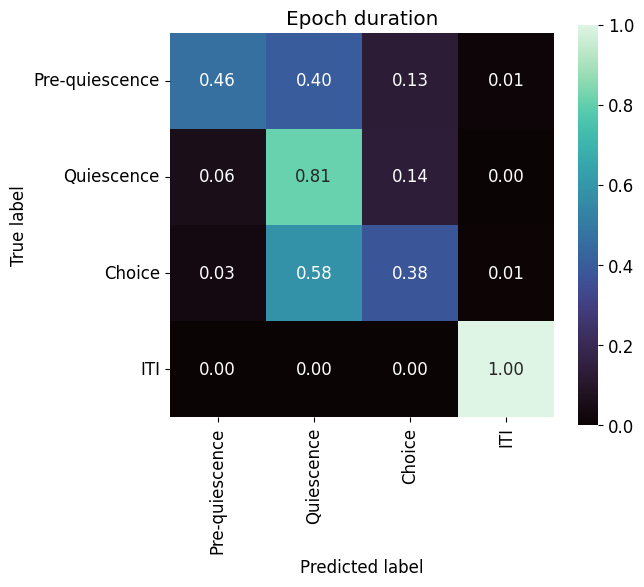

F1 results 0.6610410079949091


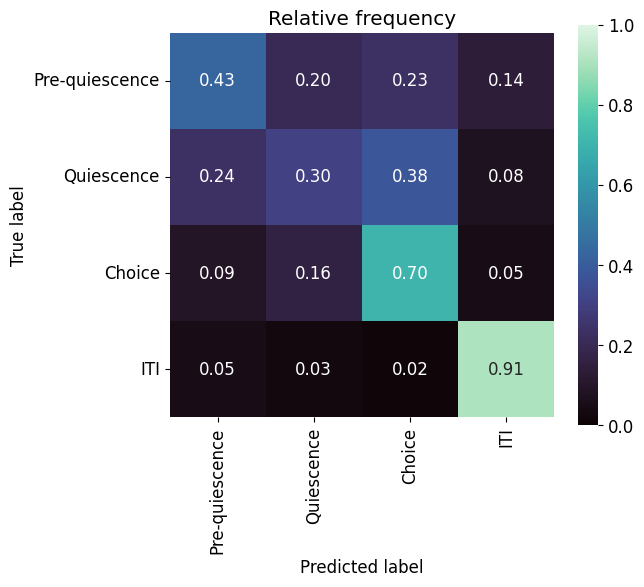

F1 results 0.5859412464242305


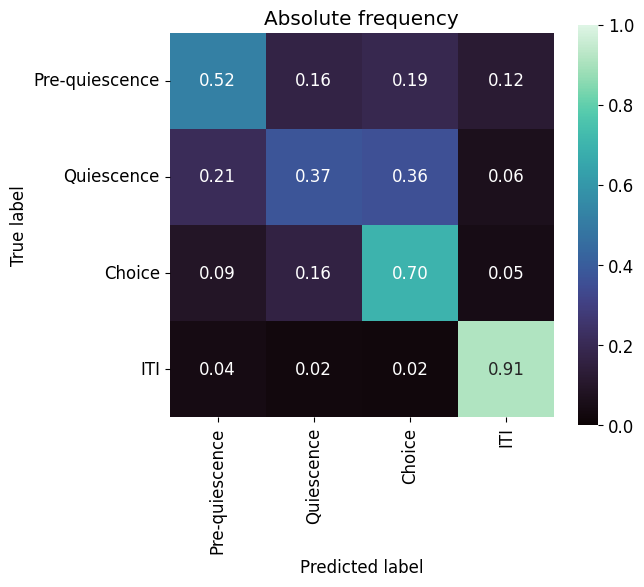

F1 results 0.6260113599644297


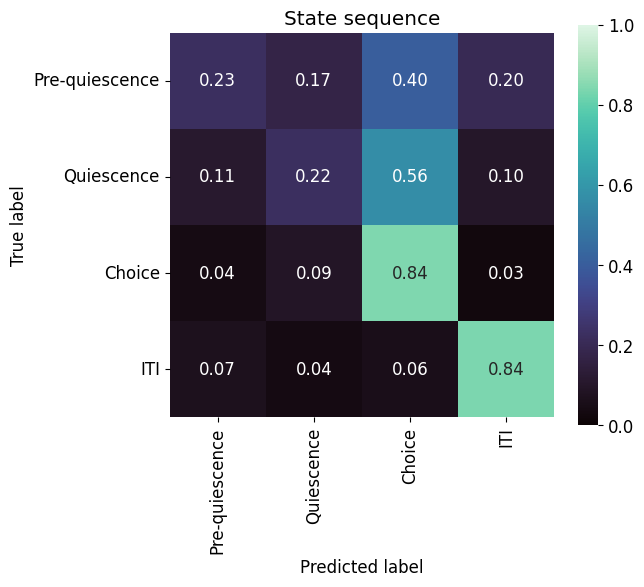

F1 results 0.5324577296690607


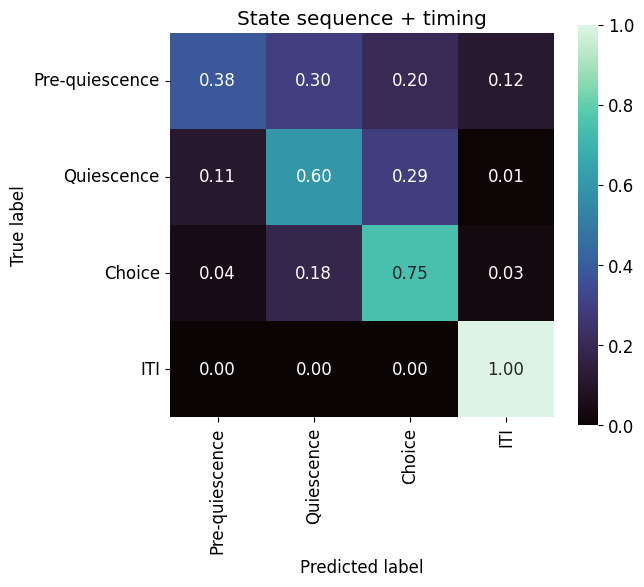

F1 results 0.6809844764654436


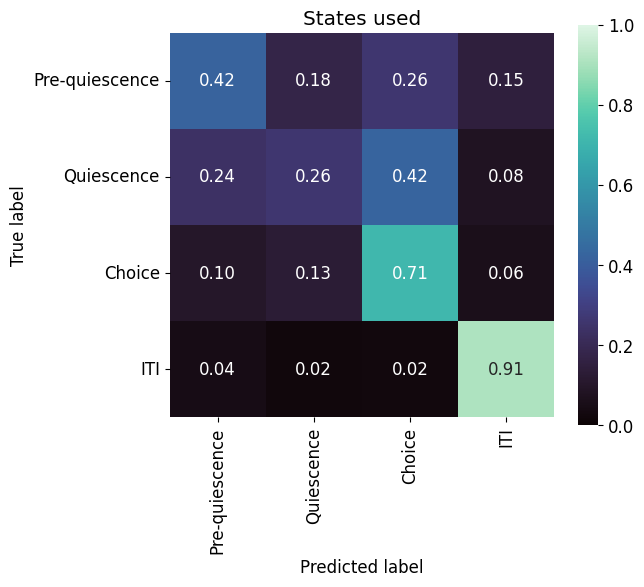

F1 results 0.5748764958965028


In [167]:
for d, decoder in enumerate(all_decoders['decoder'].unique()):
    # Results on original model
    plt.rc('font', size=12) 
    plt.figure(figsize=[6.2, 5.2])
    hmap = sns.color_palette("mako", as_cmap=True)
    data = all_decoders.loc[(all_decoders['shuffle'] == False) & (all_decoders['decoder'] == decoder)]
    sns.heatmap(data['confusion_matrix'].mean(), annot=True, square=True,
        yticklabels=trial_epochs, xticklabels=trial_epochs, 
        cmap= hmap, vmin=0, vmax=1, fmt=".2f") 

    plt.xticks([.5, 1.5, 2.5, 3.5], trial_epochs)
    plt.yticks([.5, 1.5, 2.5, 3.5], trial_epochs)
    plt.xticks(rotation = 90)
    plt.yticks(rotation = 0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(decoder)
    # plt.savefig('full_cm.svg',dpi=500)
    plt.show()
    print('F1 results', data['f1'].mean())

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Epoch duration'),
  Text(1, 0, 'Relative frequency'),
  Text(2, 0, 'Absolute frequency'),
  Text(3, 0, 'State sequence'),
  Text(4, 0, 'State sequence + timing'),
  Text(5, 0, 'States used')])

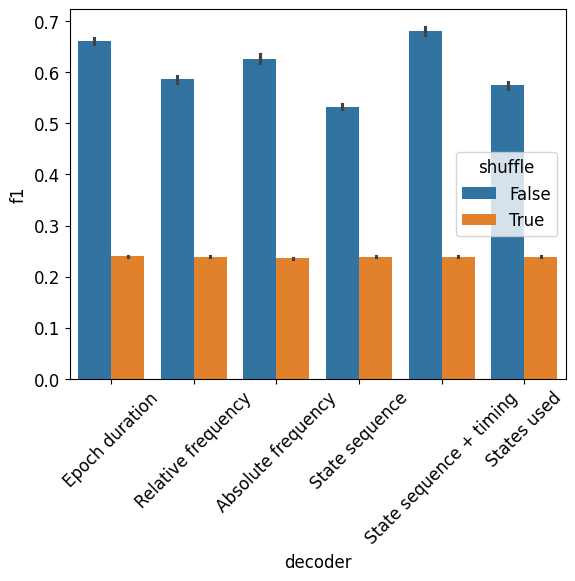

In [168]:
sns.barplot(x='decoder', y='f1', hue='shuffle', data=all_decoders)
# plt.ylim([0.2, .8])
plt.xticks(rotation=45)